# Evaluation of model error with test set 

Using the best-trained model, let's evaluate its performance comparing the predictions and real values for the test set,  using the following measurements:
- The R2-score
- Mean Absolute error  
- Mean Absolute Deviation

The values on the train set are also estimated to compare the model performance

In [1]:
%matplotlib notebook
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import  TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score, median_absolute_error
from sklearn.compose import TransformedTargetRegressor

df_hour = pd.read_csv("hour.csv")

In [2]:
def aggregate_last_n_hours(instant,n_hours):
    agg = 0
    for i in range(1,n_hours+1):
        if (instant-i <=0) or not(instant - i in df_hour.index):
            agg =+ df_hour["cnt"].mean()
        else:
            #The cnt of the instant IS EXCLUDED (.loc[instant-1-i]). That is important to avoid data leakeage
            current_index = instant-1
            agg =+df_hour["cnt"].loc[ current_index - i ]
    return agg/n_hours

def one_hot_encode(df,categorical2encode):
    for cat_var in categorical2encode:
        df = pd.concat([df,pd.get_dummies(df[cat_var],prefix=cat_var)], axis=1)
        df.drop(columns=cat_var,inplace=True)
    print("Number of model features after one-hot encoding: {}".format(len(df.columns)-1))
    return df

def split_train_test(df,fraction_train=0.8):
    train_set = df.loc[ : int(fraction_train*len(df)) -1]
    test_set =  df.loc[ int(fraction_train*len(df)) : ]
    y_train = train_set.pop("cnt")
    X_train = train_set
    y_test = test_set.pop("cnt")
    X_test = test_set
    return X_train, y_train, X_test, y_test

def compare_predictions_vs_true(y_train_pred,y_train, y_test_pred,y_test,saveplot=""):  
    plt.figure(figsize=(8,5))
    label_train = r'Train predictions: $R^2$=%.2f, $MAE$=%.2f, $MAD$=%.2f' % ( r2_score(y_train.values, y_train_pred), 
            median_absolute_error(y_train.values, y_train_pred), pd.Series(y_train_pred).mad() )
    ax1= sns.scatterplot(x=y_train.values,y=y_train_pred,label=label_train,size=0.2,color="r",alpha=0.5)
    label_test = r'Test predictions: $R^2$=%.2f, $MAE$=%.2f, $MAD$=%.2f' % ( r2_score(y_test.values, y_test_pred),
            median_absolute_error(y_test.values, y_test_pred), pd.Series(y_test.mad()) )
    sns.scatterplot(x=y_test.values,y=y_test_pred,size=0.4,label=label_test,color="b",alpha=0.4,ax=ax1)
    ax1.plot([0, 1000], [0, 1000], '--k')
    ax1.set( ylabel='Predicted target', xlabel='True Target')
    handles, labels = ax1.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if i in [0,5]]
    ax1.legend(*zip(*unique), ncol=1, loc="upper left", frameon=True)
    plt.tight_layout()
    if saveplot !="":
        plt.savefig("./report/{}.png".format(saveplot),format='png')
    return

In [3]:
# adding 3h and 1w features
names = []
for i,name in [ (3,"3h") ,(24*7,"1w")]:
    %%time df_hour[name]= df_hour["instant"].apply(lambda x: aggregate_last_n_hours(x,i)  )
    names.append(name)

Wall time: 1.5 s
Wall time: 1min 29s


In [4]:
preliminary_features = ["season","mnth","hr","holiday","weekday","workingday","weathersit","temp","hum","windspeed","cnt"]
df = df_hour[ preliminary_features + names ]

In [5]:
#encoding categorical
categorical2encode = ["season","mnth","hr","weekday","weathersit"]
df = one_hot_encode(df,categorical2encode)

Number of model features after one-hot encoding: 58


In [6]:
# train test split
X_train, y_train, X_test, y_test = split_train_test(df,fraction_train=0.8)

In [7]:
# scaling 1w and 3h using MinMaxScaler fitted to training data. Test data not used to avoide leakage 
scalers = {}
for name in ["3h","1w"]:
    scaler = MinMaxScaler()
    feature_name = name+"_scaled"
    X_train[feature_name]=scaler.fit_transform( X_train[name].values.reshape(-1, 1) )   
    X_train.drop(columns=name,inplace=True)
    scalers[name] = scaler

c:\users\c.lizarazosabogal\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\users\c.lizarazosabogal\appdata\local\programs\python\python35\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
c:\users\c.lizarazosabogal\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

In [8]:
# definning split for forward-validation
n_splits=5
tscv = TimeSeriesSplit(n_splits=n_splits)
model = ElasticNet(max_iter=3000,tol=1e-5)
# training and hyper-parameter optimization:
##sub-space of hyper-parameters:
parameters = {'alpha':[1e-3,5e-3,1e-2,5e-2,1e-1,1,5], 'l1_ratio':[0.05,0.25,0.5,0.75,1.0]}
clf_agg = GridSearchCV(model, parameters, cv=tscv,scoring="r2",n_jobs=-1)
%time clf_agg.fit(X_train,y_train)

Wall time: 24.6 s


c:\users\c.lizarazosabogal\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise-deprecating',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=3000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=1e-05, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'l1_ratio': [0.05, 0.25, 0.5, 0.75, 1.0], 'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 1, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [9]:
#transforming test set for predictions
for name in ["3h","1w"]:
    feature_name = name+"_scaled"
    X_test[feature_name] = scalers[name].transform( X_test[name].values.reshape(-1, 1) )   
    X_test.drop(columns=name,inplace=True)

c:\users\c.lizarazosabogal\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
c:\users\c.lizarazosabogal\appdata\local\programs\python\python35\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
c:\users\c.lizarazosabogal\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

<IPython.core.display.Javascript object>


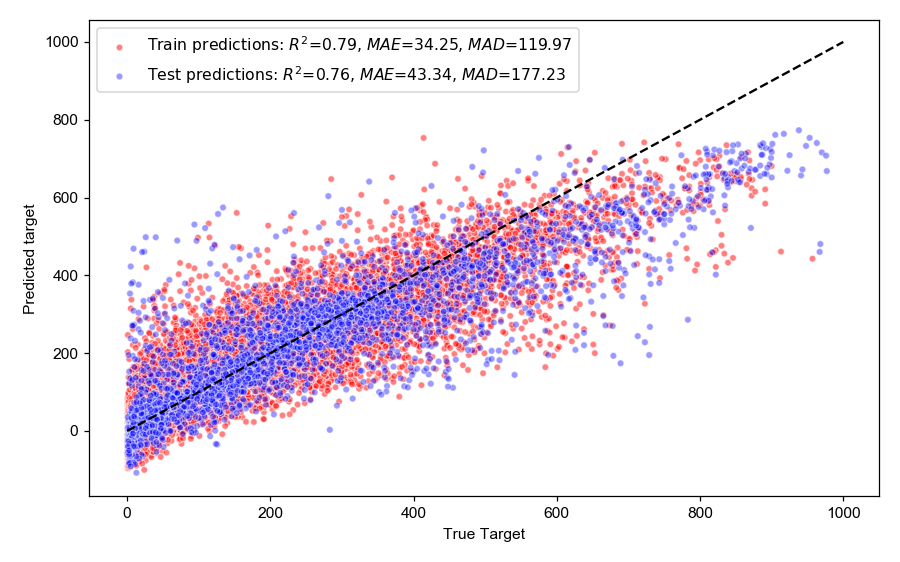

In [10]:
y_train_pred = clf_agg.predict(X_train) 
y_test_pred = clf_agg.predict(X_test)
saveplot="error_on_test_set"
compare_predictions_vs_true(y_train_pred,y_train,y_test_pred,y_test,saveplot)

### Feature Importance

<IPython.core.display.Javascript object>


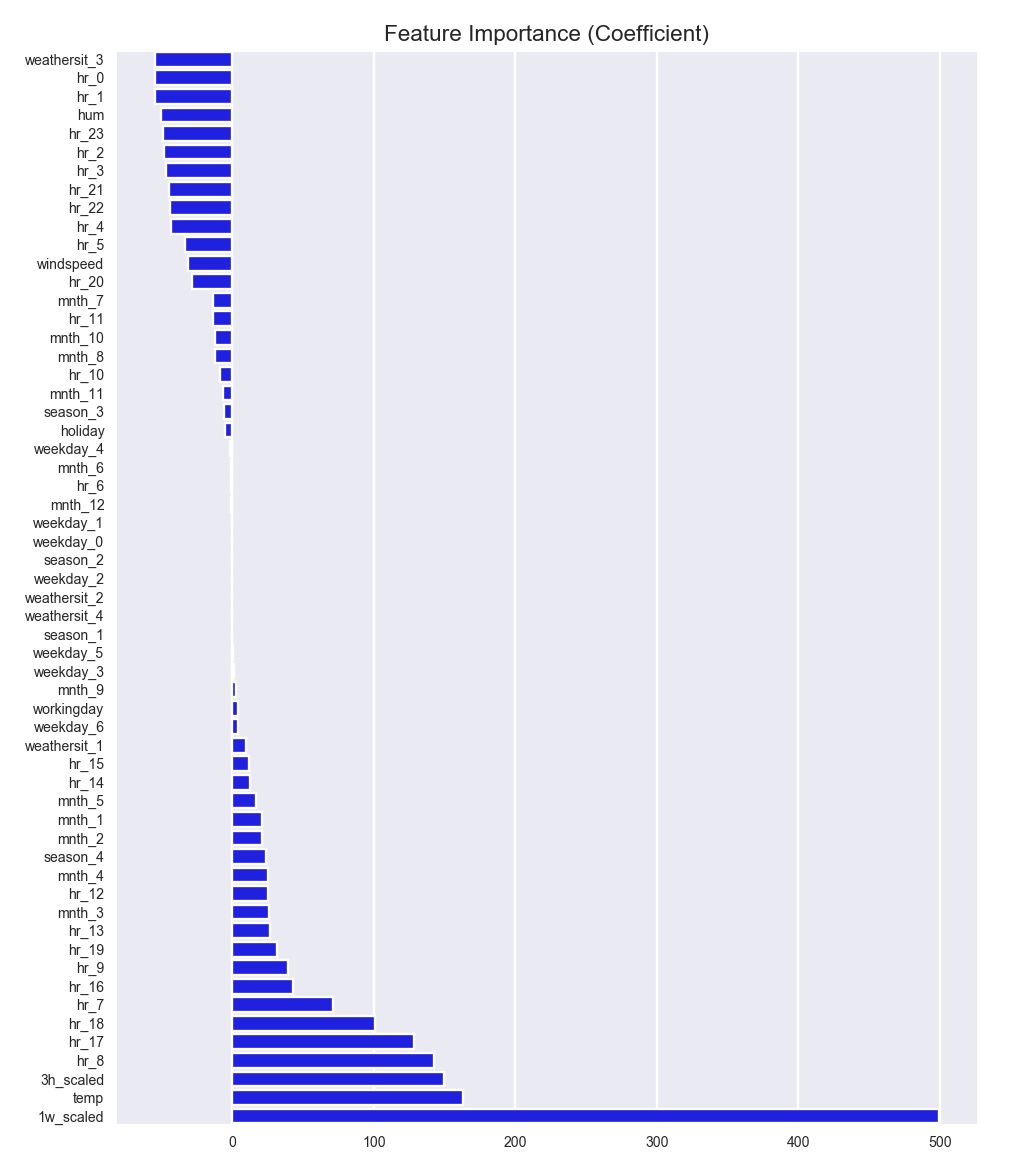

In [11]:
sns.set(style='darkgrid',context='talk',palette='Blues_r',font_scale=0.8)
sorted_coef_idx = clf_agg.best_estimator_.coef_.argsort()
coefficients =  clf_agg.best_estimator_.coef_
sorted_coef_index = coefficients.argsort()
feature_names = np.array(X_train.columns)
feature_names = feature_names[ sorted_coef_index ].astype('str')
n = 58
plt.figure(figsize=(9,0.18*n))
feat = feature_names[:]
coef = coefficients[sorted_coef_index][:]
ax = sns.barplot(y=feat,x=coef,orient='h',color='Blue')
ax.axes.set_title("Feature Importance (Coefficient)")
ax.tick_params(labelsize=9,which='major',pad=-2)
plt.tight_layout()
plt.savefig("./report/feature_importance.png",format='png')

# Model Export 

- The model has been exported into a file using pickle.
- A bunch of examples from the test data have been saved into the file *test_examples.csv* to be used as sample for inference of the model via http request to a flask application.

In [16]:
import pickle
pickle.dump(clf_agg, open('./model_export/elastic_regressor.pkl','wb'))

In [25]:
test_examples = X_test[-5:].to_csv("./model_export/test_examples.csv",header=False,index=False)

### App server

Use a console to go to *model_export* folder, then run `python server_app.py`. 
This runs a Flask web application that allows to use the exported model file 

### Client

The model can be used for inference via simple HTTP POST requests: 

In [79]:
import requests
url = 'http://localhost:5000/elastic_regressor'
filename = "./model_export/test_examples.csv"
datafile = open(filename,"r")
files = {'files': (filename, datafile)}
r = requests.request("POST", url, files=files)
r.json()

{'predictions': [79.34411330441131,
  7.2598928844332775,
  -3.203011404592445,
  -0.6210003944978411,
  -20.046357926444642]}